<a href="https://colab.research.google.com/github/davidcpage/Imagenette-experiments/blob/master/Architecture_search_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we continue investigating architectures for 5 epoch Imagenette training. Note we are using the new Imagenette2 dataset here.

### Setup

In [0]:
!python -m pip install typeguard
!python -m pip install --upgrade pillow fastprogress
!python -m pip install git+https://github.com/fastai/fastcore.git
!python -m pip install git+https://github.com/fastai/fastai2

!python -m pip install --extra-index-url https://developer.download.nvidia.com/compute/redist/cuda/10.0 nvidia-dali

UTILS = 'https://raw.githubusercontent.com/davidcpage/Imagenette-experiments/master/utils.py'
!wget $UTILS -O utils.py

In [0]:
from functools import partial
import numpy as np
import torch
import torch.nn as nn

import fastai2, fastai2.callback.all
data_dir = fastai2.basics.untar_data(fastai2.basics.URLs.IMAGENETTE_160)

device = torch.device(torch.cuda.current_device())
torch.backends.cudnn.benchmark = True

from utils import *
draw = lambda model, max_levels=-1, size=None: display(Network(model).explode(max_levels).draw(size=size))

/root/.fastai/data/imagenette2-160


### DALI Dataloaders

In [0]:
size = 128
bs = 64
random_aspect_ratio = (3/4, 4/3)
random_area = (0.35, 1.)
val_xtra_size = 32

to = lambda dtype: (lambda b: (b[0].to(dtype), b[1]))

train_dl = lambda folder, bs, dtype=torch.float16: (
        Map(to(dtype), DALIDataLoader(imagenet_train_graph(folder, size, random_aspect_ratio, random_area), bs, drop_last=True, device=device)))
valid_dl = lambda folder, bs, dtype=torch.float16: Chain(
        Map(to(dtype), DALIDataLoader(imagenet_valid_graph(folder, size, val_xtra_size), bs, drop_last=False, device=device)),
        Map(to(dtype), DALIDataLoader(imagenet_valid_graph(folder, size, val_xtra_size, mirror=1), bs, drop_last=False, device=device)),
    )

data = lambda data_dir=data_dir, bs=bs, dtype=torch.float16: fastai2.basics.DataBunch(train_dl(data_dir/'train', bs, dtype), valid_dl(data_dir/'val', bs, dtype))

### Model

In [0]:
conv = partial(fastai2.layers.ConvLayer, act_cls=MishJit)

class Residual(SplitMerge):
    def __init__(self, c, f=4, zero=True):
        conv_path = nn.Sequential(
            conv(c, c*f, groups=c),
            conv(c*f, c, norm_type=fastai2.layers.NormType.BatchZero if zero else fastai2.layers.NormType.Batch),
        )
        super().__init__([conv_path, nn.Sequential()])

def block(c_in, c_out, num_residual=0, f=4):
    return nn.Sequential(
        conv(c_in, c_in*f, groups=c_in),
        conv(c_in*f, c_out),
        nn.MaxPool2d(3,2,1),
        *[Residual(c_out, f=f) for _ in range(num_residual)]
)
    
sizes = (32, 64, 128, 256, 512)
def model(num_residual, sizes=sizes): 
    m = nn.Sequential(
        conv(3, sizes[0], stride=2),
        *[block(c_in, c_out, n) for (c_in, c_out, n) in zip(sizes[:-1], sizes[1:], num_residual)],
        nn.AdaptiveAvgPool2d(1),
        fastai2.layers.Flatten(),
        nn.Linear(sizes[-1], 10, bias=True),
    )
    fastai2.vision.models.xresnet.init_cnn(m)
    return m

In [0]:
learner = partial(fastai2.basics.Learner,
        metrics=[fastai2.metrics.accuracy, smoothed_acc],
        loss_func=fastai2.basics.LabelSmoothingCrossEntropy())

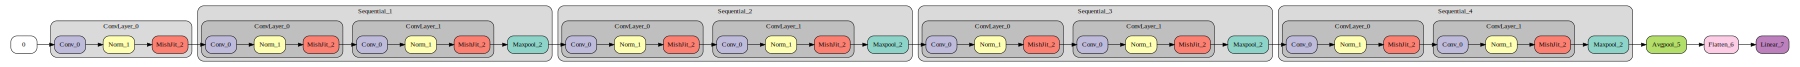

epoch,train_loss,valid_loss,accuracy,smoothed_acc,time
0,1.631273,1.659098,0.584076,0.571599,00:14
1,1.251651,1.236153,0.692484,0.677973,00:14
2,1.071199,1.145483,0.746115,0.733337,00:14
3,0.948745,0.928652,0.846497,0.830734,00:14
4,0.849359,0.889864,0.862293,0.848349,00:14


In [0]:
learn = learner(data(dtype=torch.float), model(num_residual=(0, 0, 0, 0)))
draw(learn.model, size=25)
learn.fit_one_cycle(5, lr_max=2e-2)